In [1]:
from UTILITY_quickstart import *

In [2]:
tao = initializeTao(
    inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights_driverOnly_2023-05-16InjectorMatch.h5',
    #inputBeamFilePathSuffix = '/beams/L0AFEND_facet2-lattice.h5',

    #runImpactTF=True,
    #impactGridCount=8,
    numMacroParticles=1e4,

    lastTrackedElement = "end"
)

trackBeam(tao)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
No defaults file provided to setLattice(). Using setLattice_defaults.yml
Loading default setLattice() values
Number of macro particles = 10000.0


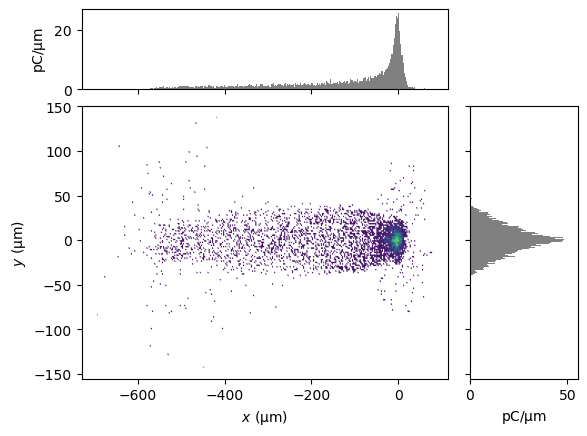

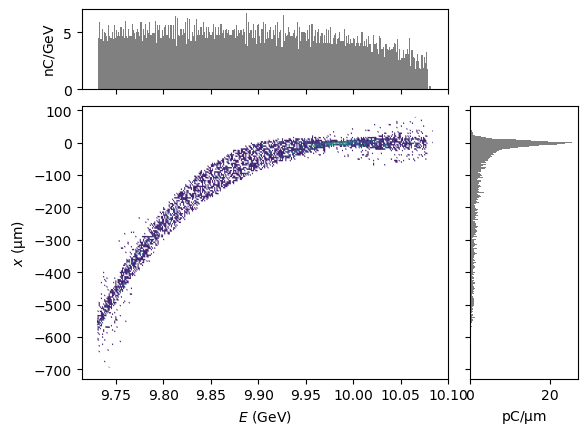

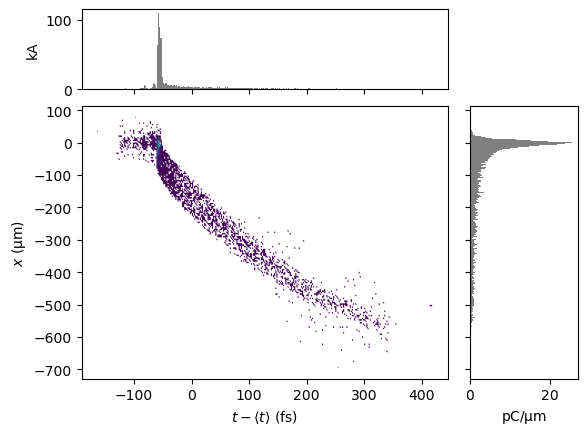

ParticleGroup with 10000 particles with total charge 1.6018414376841442e-09 C


<Figure size 640x480 with 0 Axes>

In [3]:
P = getBeamAtElement(tao, "PENT")
display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(P, 'energy', 'x',  bins=300))
display(plotMod(P, 'delta_t', 'x',  bins=300))
plt.clf()
print(P)

In [4]:
P["sigma_x"]

0.00015904836385237007

Sum counts: 9767


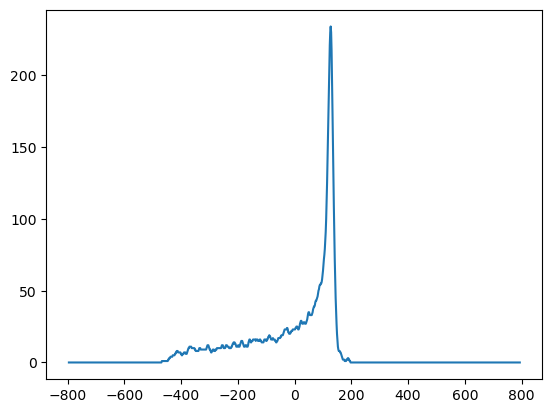

In [5]:
xData = P.x
xData = xData - np.mean(xData)

from scipy.ndimage import gaussian_filter1d
def histogramDataUnified(data):
    
    
    counts, bin_edges = np.histogram(data, 
                                     range=(
                                         np.mean(data) - 5*np.std(data),
                                         np.mean(data) + 5*np.std(data)
                                     ), 
                                     #bins = int(len(data)/100)
                                     bins = 1000
                                    )

    #Optional: Gaussian blur
    counts = gaussian_filter1d(counts, 2.0)
    
    return counts, bin_edges

# Generate histogram data
counts, bin_edges = histogramDataUnified(xData)

# Print histogram data
# print("Counts:", counts)
# print("Bin edges:", bin_edges)

print(f"Sum counts: {np.sum(counts)}")


# Plotting the histogram
plt.plot(1e6*(bin_edges[:-1]),counts)
plt.show()

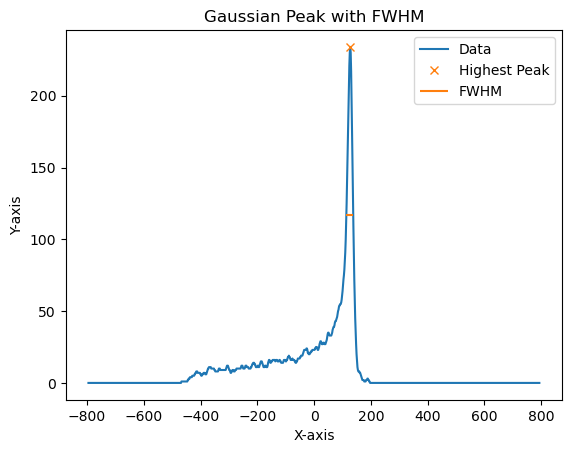

In [6]:
from scipy.signal import find_peaks, peak_widths

# Create some example data
x = 1e6*(bin_edges[:-1])
y = counts

# Find the peaks in the data
peaks, properties = find_peaks(y)

# Identify the highest peak
highest_peak = peaks[np.argmax(y[peaks])]

# Calculate the FWHM using peak_widths for the highest peak
results_half = peak_widths(y, [highest_peak], rel_height=0.5)

# Interpolate to find more accurate x positions for the half-maximum points
x_min = np.interp(results_half[2], np.arange(len(x)), x)
x_max = np.interp(results_half[3], np.arange(len(x)), x)

# Plot the data, the highest peak, and the FWHM
plt.plot(x, y, label='Data')
plt.plot(x[highest_peak], y[highest_peak], 'x', label='Highest Peak')
plt.hlines(results_half[1], x_min, x_max, color='C1', label='FWHM')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Gaussian Peak with FWHM')
plt.show()


In [7]:
fwhm = (x_max-x_min)[0]
impliedRMS = fwhm / 2.355
print(f"""Actual RMS = \t\t\t{1e6*P["sigma_x"]}""")
print(f"FWHM = \t\t\t\t{fwhm} \nImplied (Gaussian) RMS = \t{impliedRMS}")

Actual RMS = 			159.04836385237007
FWHM = 				24.23011521106251 
Implied (Gaussian) RMS = 	10.288796267967095


In [8]:
np.sum(counts)

9767

In [11]:
results_half

(array([15.23443223]),
 array([117.]),
 array([571.38461538]),
 array([586.61904762]))

In [15]:
#Triangle approximation
